# 🏎️ A Reinforcement Learning approach to the Racetrack problem

<small>[📖 Exercise 5.4: Racetrack (programming)](http://incompleteideas.net/book/ebook/node56.html) of Sutton and Barto's *Reinforcement Learning: An Introduction* book (second edition).</small>

<figure width="20%" style="float: right;">
  <img src="./utils/Track1.png">
  <figcaption align="center">Fig.1 - Example of Racetrack</figcaption>
</figure>

Let's consider driving a race car around a turn like those shown in Figure 1. We want to go as fast as possible, but not so fast as to run off the track.
We start at a random position on the starting line (the green area), with both velocity components equal to zero. At each step, we decide to change each component by $+1$, $-1$, or $0$ (but always keeping each component lower or equal to $3$, and never stopping during the race). The episode ends when we cross the finish line (the red area). If we hit the track boundary, we are moved back to a random position on the starting line, both velocity components are reduced to zero, and the episode continues.

Is it possible to learn an optimal policy (i.e., learn how to reach the ending line from the starting line, going as fast as possible), without explicitly knowing the Racetrack model?

We can address this problem by considering as a **Reinforcement Learning** problem:
* at each time step, the car has a **state**, described by the current position and the current velocity (i.e., the state is a tuple of the form `(x_pos, y_pos, x_vel, y_vel)`);
* an external Agent can interact with the enviroment, take **actions** and observe the output state (the possible action are in the form `(x_vel_d, y_vel_d)`, with both `x_vel_d` and `y_vel_d` choosen between $-1$, $0$ and $+1$). The goal of the Agent is to reach the ending line minimizing the number of steps taken.

One possible way to reach our goal, and in fact it is whay we are going to study in this project, is to use Temporal Difference learning by applying different approaches and compraring the results.

## Problem settings

We start by importing some useful libraries that we are going to use in the following (canonical libraries such as `numpy` or `matplotlib`, nothing very special here).\
We are also defining functions that will be useful later on in the notebook, mainly for results visualization puposes.

In [1]:
# Import useful libraries
import numpy as np
np.random.seed(0) # Set random seed for reproducibility
from matplotlib import pyplot as plt
from tqdm import tqdm
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO) # Set notebook logging level
logging.getLogger('racetrack').setLevel(logging.INFO) # Set racetrack library logging level

TRAIN_CONTROL = False # Set to False to skip training and load a pre-trained control

# Define functions for plotting Monte Carlo control results
def plot_control_performances(control, color='steelblue'):
    """
    Plot the learning performances of the given control object.
    """

    # Plot the rewards during the SARSA Control training

    fig = plt.figure( figsize=(11, 5) )

    ax0 = fig.add_subplot(1, 1, 1)

    ax0.set_title(f"{control.name} Performances", fontsize=16, y=1.1)
    ax0.plot(control.performances, c=color, lw=1.)
    ax0.xaxis.tick_top()
    ax0.set_yscale('symlog')
    ax0.set_xlabel("Epochs")
    ax0.xaxis.set_label_position('top') 
    ax0.set_ylabel("Rewards")

    # Hide the right and bottom spines
    ax0.spines['right'].set_visible(False)
    ax0.spines['bottom'].set_visible(False)

    ax0.legend([control.name])

    plt.show()


    # Plot the performances of the SARSA Control
    #plot_control_performances(sarsa_control)

def plot_sample_trajectories(control, trajectories=[2_500, 5_000, 7_500]):

    fig = plt.figure(figsize=(11, 5))

    gs = fig.add_gridspec(1,len(trajectories))

    fig.suptitle(f"{control.name} Trajectories", fontsize=16, y=1)

    for idx, trajectory_no in enumerate(trajectories):

        ax = fig.add_subplot(gs[0, idx])

        ax.set_xticks(np.arange(-1, control.environment.width, 1)+.5)
        ax.set_xticklabels([])
        ax.set_yticks(np.arange(-1, control.environment.height, 1)+.5)
        ax.set_yticklabels([])
        ax.tick_params(left = False, bottom = False)
        ax.grid(True, axis='both', lw=.5, c='black')
        ax.tick_params(axis='x', length=0)
        ax.set_aspect('equal')

        ax.set_title(f"Trajectory no. {trajectory_no}")
        control.environment.track._plot_track(ax=ax)
        control._plot_trajectory(ax=ax, trajectory_no=trajectory_no)

    plt.show()

print("✅ Setup complete.")

✅ Setup complete.


Once done, let's focus on the problem itself. The `racetrack` library contains the definition of some classes for the specific problem handling:

* `TrackEnv` class: this is the actual interface we are going to use to interact with the Race track. Note that in this scenario we can only observe *(state, action)* couples, without knowing *a priori* the transition probabilities and rewards of the system. This is exactly what turns our problem into a **Model-free problem**;
* `TDLearing` class: this is the class used to control the environment. In the definition of the object, an agent between `SARSA`, `QLearning` and `ExpSARSA` has to be specified in order to choose which apprach to follow to calculate the *TD error* $\delta$.

Let's import the above classes, and define constants of our problem (such as `MAX_VELOCITY` of the car in any direction, or the list of possible `ACTIONS` an Agent can choose from).

Example of state (6, 26, 3, 2) in the race track:


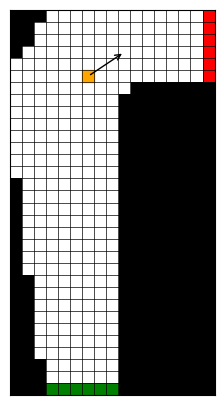

In [2]:
from racetrack import TrackEnv

# Set global constants
MAX_VELOCITY = 3 # Maximum velocity for each direction (X and Y)
ACTIONS = np.array([(-1,-1), (-1, 0), (-1,+1), ( 0,-1), ( 0, 0), ( 0,+1), (+1,-1), (+1, 0), (+1,+1)])

# Define the TrackEnv object that will be used for learning
track_env = TrackEnv(max_velocity=MAX_VELOCITY)

# Render an example of state istance on the track environment
track_env.current_state = (6, 26, 3, 2) # The state is in the form (x_pos, y_pos, x_vel, y_vel)
print(f"Example of state {track_env.current_state} in the race track:")
track_env.render(plot_track=True)

Note that the actual shape of the track is only visible to us for debugging purposes: the Agent that interacts with the environment will never have such a detailed description of the racetrack available to it. The only way to learn how to optimally reach the goal, is to interact with the environment and take actions based on the resulting observations following some sort of *trial and error* behaviour.

## Temporal-Difference Control

<small>[📖 Chapter 6: Temporal-Difference Learning](http://incompleteideas.net/book/ebook/node60.html) of Sutton and Barto's *Reinforcement Learning: An Introduction* book (second edition).</small>

The problem we want to address in this project is to find the optimal policy an Agent should follow when interacting with the `TrackEnv` environment, in order to minimize the cost of reaching the ending line starting from a random position on the starting line. This is a tipical scenario in (RL) **Control problems**.

There are many approches that can be used to learn how to control a MDP without a model (i.e., in a *model-free* case).\
We will explore three of the most important ones, that are:
* SARSA,
* Q-Learning,
* Expected SARSA.

All of this are Temporal-Difference Learning algorithms, which means that they share a common behaviour.\
In particular, what a TD Learning algorithm do is:

1. It starts with an estimate of the value function $\hat{Q}$, that might or might not encode a prior knowledge of the system and took an initial state $S$.
2. From $\hat{Q}$, a policy $\pi$ is derived, balancing exploration and exploitation (e.g., using an *$\epsilon$-greedy* approach).
3. From the policy $\pi$, an action $A$ is produced.
4. Applying the action to the current state $S$ of the system, a reward $R$ and a new state $S'$ are observed.
5. It computes the eligibility matrix $e$ and the *TD-error* $\delta$ following some formula. This is where the three cites algorithms differ, with consequences that we will explain later on.
6. It update the $\hat{Q}$ matrix by adding $\alpha \times \delta \times e$ to it.
7. It updates the current state with $S'$, and loop from the second point until some termination condition (e.g., until convergence).

Since in the following we are only focusing on *TD(0)* Control, the eligibility matrix $e$ is simply updated as

$$
    e(s,a) = \mathbb{1}(s=S_t, a=A_t).
$$

Also, we are keeping fixed the parameter $\epsilon$ for the *$\epsilon$-greedy* approach and the learning rate $\alpha$. This is of course a limitation of our project, that can be overcome in furter studies.

In [3]:
# Define common control parameters
N_EPISODES  = 10_000 # The number of episodes to run
                     # the control algorithm for each TD Learning algorithm
GAMMA       = 1.00   # The discount factor
LR_V        = 0.75   # The learning rate for the value function
EPSILON     = 0.05   # The epsilon value for the epsilon-greedy policy

### SARSA: on-policy TD Control

<small>[📖 Chapter 6.4: Sarsa: On-Policy TD Control](http://incompleteideas.net/book/ebook/node64.html) of Sutton and Barto's *Reinforcement Learning: An Introduction* book (second edition).</small>

<figure style="float: center;">
  <img src="./utils/sarsa_pseudocode.jpg">
  <figcaption align="center">Fig.2 - SARSA pseudocode</figcaption>
</figure>

The first possibility to computer the *Temporal-Difference error* $\delta$ is by following an algorithm called **SARSA**. The name is an acronym that comes from **S**tate, **A**ction, **R**eward, new **S**tate, new **A**ction, because the way in which $\delta$ is computer requires the evaluation of an additional state and an addictional action.\
Formally, $$\delta = R' + \gamma Q(S',A') - Q(S,A).$$
One crucial observation in SARSA is that the policy to choose the current action $A$ and the new action $A'$ is exactly the same (a policy derived from $Q$).

Let's define a `SARSA` object and run 10 000 episodes following the algorithm described above (actually, we already ran this step, and what we are actually doing is simply load the pre-trained object from the filesystem 🤫).

In [4]:
from racetrack import SARSA

sarsa_control = SARSA(environment=track_env, gamma=GAMMA, lr_v=LR_V, epsilon=EPSILON)

# Load the Control object from filesystem (instead of training it again)
if TRAIN_CONTROL:
    sarsa_control.control(n_episodes=N_EPISODES)
else:
    sarsa_control = sarsa_control.load()

2023-10-22 13:03:04.405 INFO racetrack - load: SARSA Control restored from ./data/SARSA_Control.pkl file.


We can visualize how the rewards of the different episodes are distributed throug time.

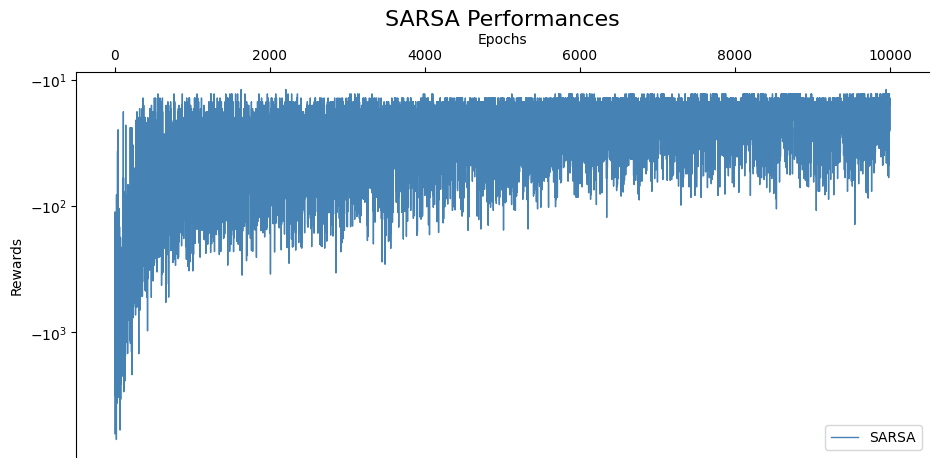

In [5]:
# Plot the rewards during the SARSA Control training
plot_control_performances(sarsa_control, color='steelblue')

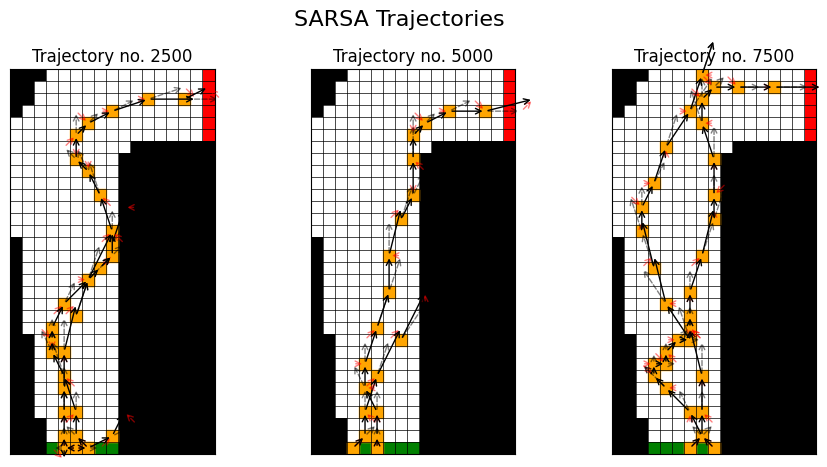

In [6]:
# Plot three sample trajectories from the SARSA Control training
plot_sample_trajectories(control=sarsa_control)

Looking at the learning curve and the sample trajectories, it is clear that the SARSA Agent did not reached a complete optimal policy, but it is still able to drive the car to the finish line in a reasonable number of steps.\
We expect to imporve this results with the next two algorithm that are being presented.

### Q-Learning: off-policy TD Control

<small>[📖 Chapter 6.5: Q-Learning: Off-Policy TD Control](http://incompleteideas.net/book/ebook/node65.html) of Sutton and Barto's *Reinforcement Learning: An Introduction* book (second edition).</small>


<figure style="float: center;">
  <img src="./utils/qlearning_pseudocode.jpg">
  <figcaption align="center">Fig.3 - Q-Learning pseudocode</figcaption>
</figure>

Another choice for computing the *Temporal-Difference error* is called **Q-Learning**, and it is defined as $$\delta = R' + \gamma \max_{a'} Q(S',a') - Q(S,A).$$

Note that, differently from SARSA, even if in the exploration phase Q-Learning choose the action using an *$\epsilon$-greedy* approach (meaning that the trajectories can follow a non-optimal solution), during the evaluation phase we are only evaluating the new space using a greedy policy. In this sense, **Q-Learning** is an off-policy Control.

In [7]:
from racetrack import QLearning

qlearning_control = QLearning(environment=track_env, gamma=GAMMA, lr_v=LR_V, epsilon=EPSILON)

# Load the Control object from filesystem (instead of training it again)
if TRAIN_CONTROL:
    qlearning_control.control(n_episodes=N_EPISODES)
else:
    qlearning_control = qlearning_control.load()

2023-10-22 13:03:38.468 INFO racetrack - load: QLearning Control restored from ./data/QLearning_Control.pkl file.


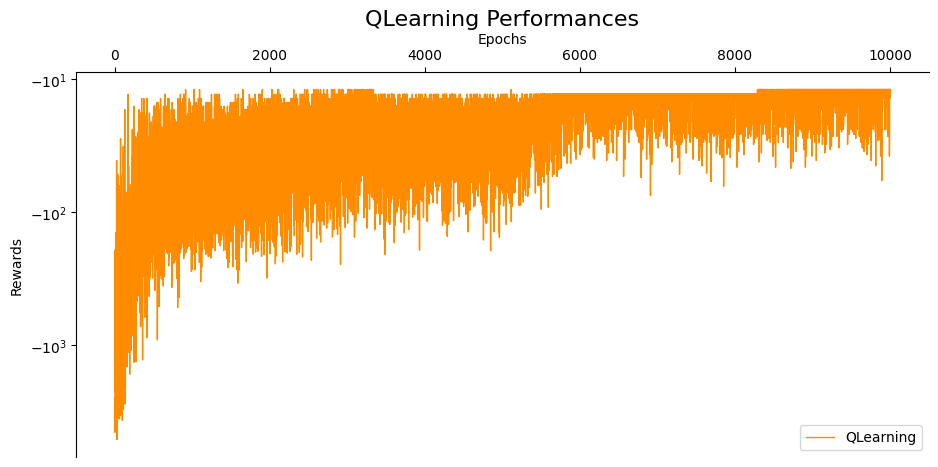

In [8]:
# Plot the performances of the Q-Learning Control
plot_control_performances(qlearning_control, color='darkorange')

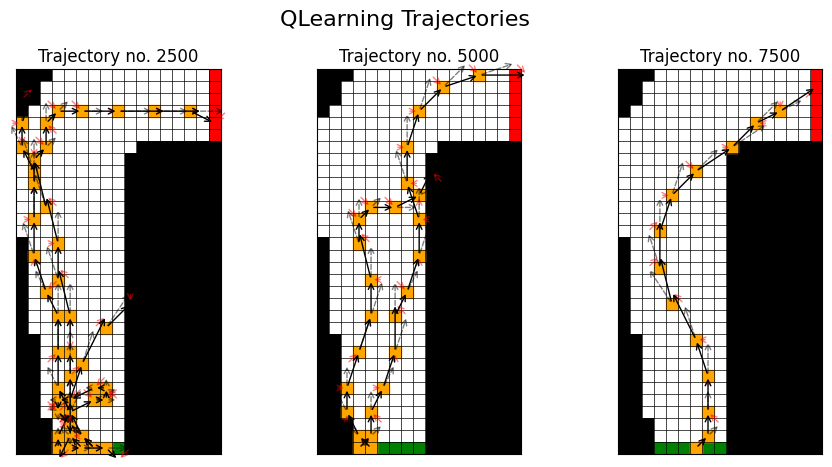

In [9]:
# Plot three sample trajectories from the Q-Learning Control training
plot_sample_trajectories(control=qlearning_control)

### Expected SARSA

The third algorithm that we are going to use to compute the *Temporal-Difference error* is called **Expected SARSA**. It is a modification of the above descripted SARSA algorithm, since it averages over all the possible actions in the new state $S'$ weighted by the current policy $\pi(A\mid S)$. The way in which it works is $$\delta = R' + \gamma \sum_{a'}\pi(a'\mid S')Q(S',a') - Q(S,A).$$

Note that, since we are using the current $\pi$ for the evaluation, this is still an on-policy TD control.\
It is possible to use Expected SARSA in an off-policy way, if the update step uses a different weighting $\tilde{\pi}(A\mid S)$ for action choices than the policy that actually took the action.

In [10]:
from racetrack import ExpectedSARSA

expsarsa_control = ExpectedSARSA(environment=track_env, gamma=GAMMA, lr_v=LR_V, epsilon=EPSILON)

# Load the Control object from filesystem (instead of training it again)
if TRAIN_CONTROL:
    expsarsa_control.control(n_episodes=N_EPISODES)
else:
    expsarsa_control = expsarsa_control.load()

2023-10-22 13:04:30.571 INFO racetrack - load: ExpectedSARSA Control restored from ./data/ExpectedSARSA_Control.pkl file.


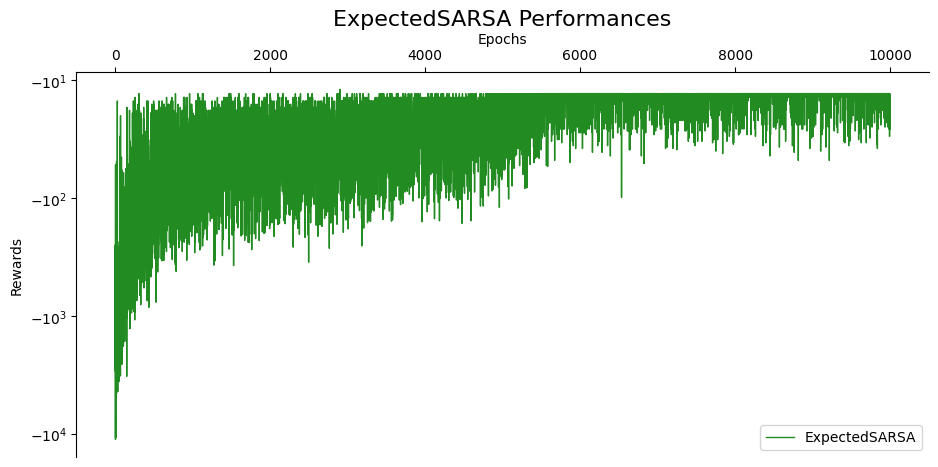

In [11]:
# Plot the performances of the Expected SARSA Control
plot_control_performances(expsarsa_control, color='forestgreen')

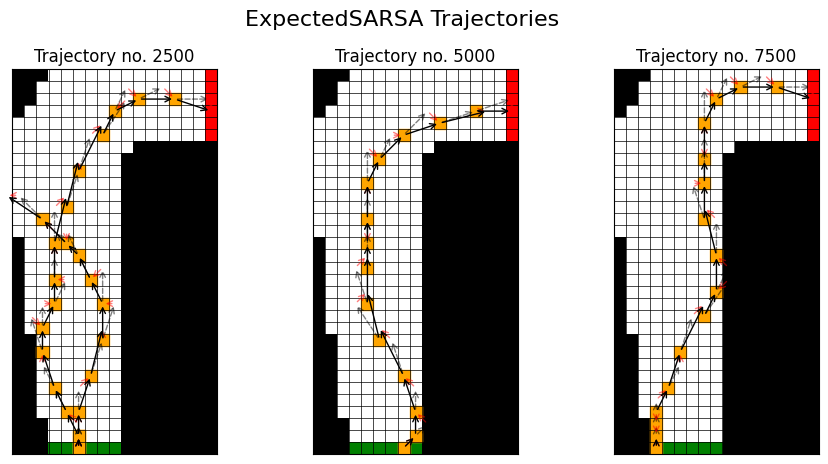

In [12]:
# Plot three sample trajectories from the Expected SARSA Control training
plot_sample_trajectories(control=expsarsa_control)

### Results

We can now put together the results from all the algorithms that we have studied, and take final observation.

First of all, let's visualize all the learning curves in a single plot and compare them.

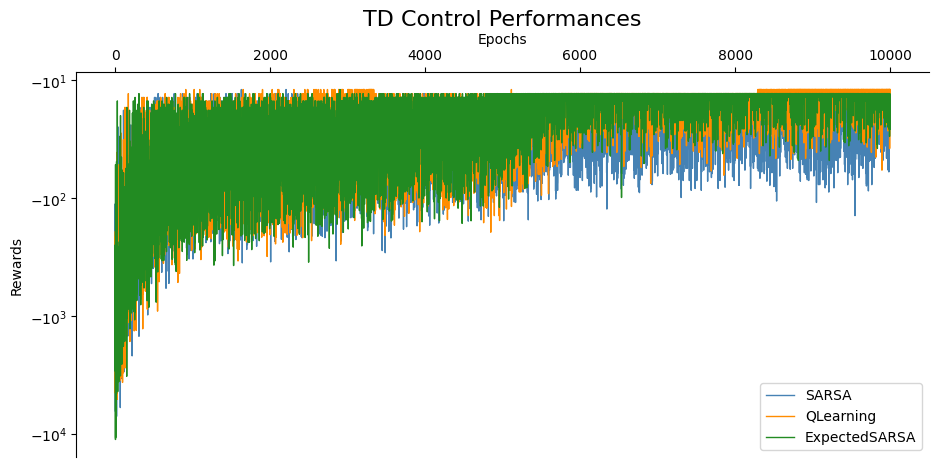

In [15]:
# Plot all the performances together for comparison purposes

fig = plt.figure( figsize=(11, 5) )

ax0 = fig.add_subplot(1, 1, 1)

ax0.set_title(f"TD Control Performances", fontsize=16, y=1.1)
ax0.plot(sarsa_control.performances, c='steelblue', lw=1.)
ax0.plot(qlearning_control.performances, c='darkorange', lw=1.)
ax0.plot(expsarsa_control.performances, c='forestgreen', lw=1.)
ax0.xaxis.tick_top()
ax0.set_yscale('symlog')
ax0.set_xlabel("Epochs")
ax0.xaxis.set_label_position('top') 
ax0.set_ylabel("Rewards")

# Hide the right and bottom spines
ax0.spines['right'].set_visible(False)
ax0.spines['bottom'].set_visible(False)

ax0.legend([sarsa_control.name, qlearning_control.name, expsarsa_control.name])

plt.show()

From the plot above, we can see some interesting results:
* SARSA is the algorithm that has the highest variance in the rewards, and after 10,000 epochs it has not yet converged to a stable solution.
* Q-Learning reaches the best performance of all the three algorithms, but it is less consistent than Expected SARSA.
* Expected SARSA is the algorithm that reaches a stable solution faster than the other two algorithms, with a variance that is slighlty lower than Q-Learning.

Furthermore, none of the algorithms reached a stable solution after 10,000 epochs, so we can expect that the performances will improve even more if we train them for a longer period of time, or better if we hyper-tune the parameters of the algorithms. Further considerationson this in the [Possible future improvements](#possible-future-improvements) section.

/home/enstit/.local/lib/python3.9/site-packages/matplotlib/text.py:1242: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


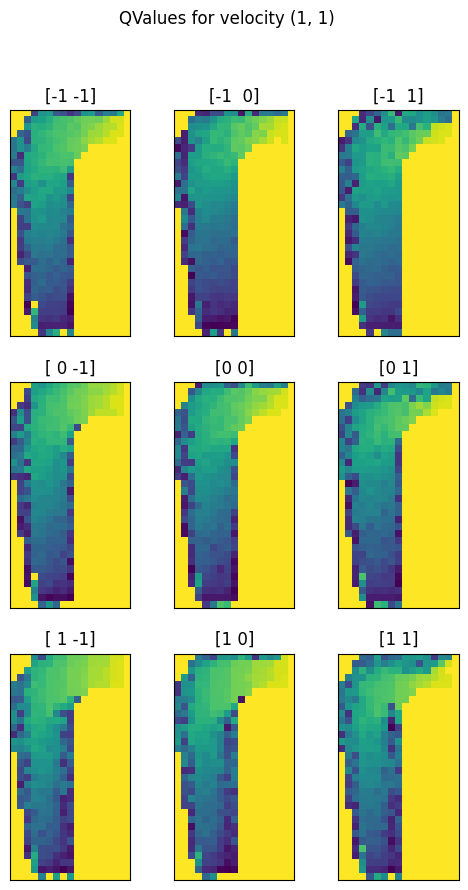

In [14]:
fig, ax = plt.subplots(3,3, figsize=(6,10))

velocity = (1,1)

fig.suptitle(f"QValues for velocity {velocity}")
for n in range(9):
    ax[n//3, n%3].set_title(ACTIONS[n])
    ax[n//3, n%3].imshow(expsarsa_control.Qvalues[:,:,1,1,n].T, origin='lower', aspect='equal')
    ax[n//3, n%3].set_xticklabels([])
    ax[n//3, n%3].set_yticklabels([])
    ax[n//3, n%3].tick_params(axis='both', length=0)

plt.show()

## Possible future improvements

* Generalise the code of the `TDLearning` class by introducing a variable `lambda_` so that it possible to implement a *TD($\lambda$)* control.
* Generalise the code of `QLearning` by parametrizing the estimation policy $\tilde{\pi}$ (if $\tilde{\pi} = \argmax Q$, then the algorithm is equivalent to the current implementation of QLearning, while when $\tilde{\pi} = \pi$ the algorithm is equivalent to Expected SARSA). Any value in the middle mix on-policy and off-policy controls.
* To ensure the convergence of the solution, a variable learning rate $\alpha$ should be used.\
    In particular, it has to respect two criterions:
    1. $\sum_t \alpha_t^2$ must converge;
    2. $\sum_t \alpha_t$ must diverge.
* To optimize the control, it should be considered an epsilon $\epsilon$ for the epsilon-greedy policy that also take into consideration the number of times the current `(state-action)` has been visited.
* Find way to visualize the Q-values space (4 dimensions)